In [10]:
import os
import time
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
from catanatron_gym.envs.catanatron_env import ACTION_SPACE_SIZE
from catanatron_gym.features import get_feature_ordering

In [11]:
# ===== Ensure datasets exists
import pathlib
import urllib.request

# Set appropriately in cloud environments
DOWNLOAD_FROM_INTERNET = False
DATA_FOLDER = "../../../data/vf-1v1"
VALIDATION_DATA = DATA_FOLDER + '-validation'

DATASET_PATH = pathlib.Path(DATA_FOLDER, "main.csv.gzip")
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA, "main.csv.gzip")

if DOWNLOAD_FROM_INTERNET:
    DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    VALIDATION_DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    if not DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard/main.csv.gzip", DATASET_PATH)
    if not VALIDATION_DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard-validation/main.csv.gzip", VALIDATION_DATASET_PATH)

489200 samples
290 classes
Counter({0: 167946, 289: 165529, 20: 9623, 201: 4714, 237: 3175, 238: 3150, 241: 2795, 229: 2788, 2: 2688, 3: 2521, 239: 2513, 4: 2403, 5: 2389, 1: 2313, 6: 2303, 7: 2252, 242: 2087, 202: 2034, 233: 1761, 9: 1426, 13: 1376, 17: 1359, 11: 1355, 45: 1315, 231: 1268, 40: 1252, 49: 1238, 19: 1236, 52: 1227, 56: 1221, 39: 1219, 15: 1215, 58: 1203, 42: 1198, 44: 1196, 37: 1187, 47: 1183, 55: 1175, 33: 1173, 50: 1163, 60: 1162, 51: 1156, 34: 1125, 248: 1118, 35: 1103, 8: 1074, 103: 929, 106: 918, 110: 918, 112: 912, 12: 901, 107: 899, 115: 891, 10: 881, 101: 877, 111: 867, 104: 866, 100: 847, 16: 843, 18: 828, 43: 826, 14: 826, 116: 818, 114: 812, 235: 805, 38: 804, 57: 797, 62: 796, 53: 785, 54: 777, 27: 775, 245: 775, 23: 772, 41: 770, 59: 767, 46: 765, 61: 763, 48: 762, 230: 761, 25: 758, 31: 741, 32: 737, 36: 734, 29: 715, 22: 674, 24: 670, 99: 669, 109: 665, 95: 651, 93: 646, 108: 642, 105: 640, 96: 632, 102: 628, 113: 615, 26: 612, 94: 611, 28: 611, 243: 603, 

<AxesSubplot:>

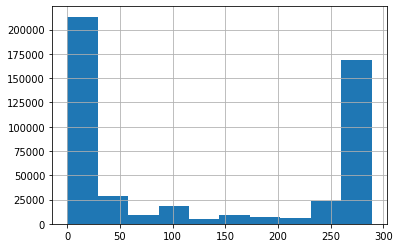

In [13]:
import pathlib
from collections import Counter

ACTIONS_DATASET_PATH = pathlib.Path(DATA_FOLDER, "actions.csv.gzip")
LABEL_COLUMN = "ACTION"

df = pd.read_csv(ACTIONS_DATASET_PATH, compression="gzip")
NUM_SAMPLES = df.shape[0]
class_distribution = Counter(df[LABEL_COLUMN])
NUM_CLASSES = max(class_distribution.keys()) + 1
print(NUM_SAMPLES, 'samples')
print(NUM_CLASSES, 'classes')
print(class_distribution)
df[LABEL_COLUMN].hist()

In [15]:
data = pd.read_csv(DATASET_PATH, nrows=10, compression='gzip')
validation_data = pd.read_csv(VALIDATION_DATASET_PATH, nrows=10, compression='gzip')
INPUT_COLUMNS = list(filter(lambda x: x.startswith("F_"), data.columns))

assert (data.columns == validation_data.columns).all()
data

,F_BANK_BRICK,F_BANK_DEV_CARDS,F_BANK_ORE,F_BANK_SHEEP,F_BANK_WHEAT,F_BANK_WOOD,"F_EDGE(0, 1)_P0_ROAD","F_EDGE(0, 1)_P1_ROAD","F_EDGE(0, 20)_P0_ROAD","F_EDGE(0, 20)_P1_ROAD",...,F_TILE9_IS_WHEAT,F_TILE9_IS_WOOD,F_TILE9_PROBA,ACTION,ACTION_TYPE,RETURN,DISCOUNTED_RETURN,TOURNAMENT_RETURN,DISCOUNTED_TOURNAMENT_RETURN,VICTORY_POINTS_RETURN
0,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,106,4,1.0,0.47534,1010.0,480.093442,9.926269
1,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,45,3,1.0,0.47534,1010.0,480.093442,9.926269
2,19.0,25.0,19.0,18.0,19.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,114,4,1.0,0.47534,1010.0,480.093442,9.926269
3,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,51,3,1.0,0.47534,1010.0,480.093442,9.926269
4,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
5,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,1.0,0.47534,1010.0,480.093442,9.926269
6,17.0,25.0,18.0,18.0,16.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
7,17.0,25.0,18.0,18.0,16.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,1.0,0.47534,1010.0,480.093442,9.926269
8,17.0,25.0,18.0,18.0,13.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
9,17.0,25.0,17.0,18.0,12.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,243,11,1.0,0.47534,1010.0,480.093442,9.926269


In [16]:
# ===== Read Dataset
BATCH_SIZE = 128
SHUFFLE_SEED = 1

dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,  # shuffle will shuffle at the element level. nice.
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)
validation_dataset = tf.data.experimental.make_csv_dataset(
    str(VALIDATION_DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)

def preprocess(batch, label):
    features = tf.stack(
        [tf.cast(tensor, tf.float32) 
         for feature_name, tensor in batch.items() 
         if feature_name in INPUT_COLUMNS
        ], axis=1
    )
    return features, tf.stack(label)

dataset = dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

In [17]:
# 10 takes 1sec. 100 batches take 4 secs. 1000 takes 50 secs.
t1 = time.time()
def take_samples(x, y):
    return x

normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalization_layer.adapt(dataset.map(take_samples).take(1000))
print("Normalization took:", time.time() - t1)
print(normalization_layer.mean)

Normalization took: 109.91870856285095
<tf.Variable 'mean:0' shape=(614,) dtype=float32, numpy=
array([1.77288628e+01, 2.40537987e+01, 1.64037971e+01, 1.63996239e+01,
       1.57980423e+01, 1.73497944e+01, 9.57421884e-02, 9.78202447e-02,
       9.77734774e-02, 9.82032120e-02, 7.36329108e-02, 7.50000551e-02,
       9.77344438e-02, 9.82499868e-02, 1.08250089e-01, 1.10039093e-01,
       1.53632790e-01, 1.53890699e-01, 6.87734112e-02, 6.88594356e-02,
       1.65593803e-01, 1.64554730e-01, 5.77969179e-02, 5.75156435e-02,
       1.62960917e-01, 1.63554728e-01, 1.78375021e-01, 1.79093838e-01,
       6.07968904e-02, 6.05390780e-02, 1.63921893e-01, 1.66468680e-01,
       5.89765906e-02, 5.94141260e-02, 1.77804768e-01, 1.80703208e-01,
       1.57351658e-01, 1.58101365e-01, 1.60164118e-01, 1.58531383e-01,
       1.57367364e-01, 1.58007905e-01, 6.40468970e-02, 6.28515556e-02,
       6.58359230e-02, 6.41484261e-02, 1.67203352e-01, 1.69375032e-01,
       1.62429601e-01, 1.61375105e-01, 7.50469193e-0

In [18]:
counts_array = np.array([class_distribution[i] for i in range(NUM_CLASSES)]).astype(np.float32)

weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)
weights[weights == np.inf] = -np.inf  # Drop inf to min value (to sort of "clip" importance)
weights[weights == -np.inf] = np.max(weights)  # Drop inf to min value (to sort of "clip" importance)
class_weight = {i: weights[i] for i in range(NUM_CLASSES)}
pprint(class_weight)

# {0: 0.010215329, then many in 0.5-2 range, 289: 0.010377976}

# === Rejection Resampling
# def class_func(features, label):
#     return label

# target_dist = [1.0 / NUM_CLASSES if i != 2 else 0 for i in range(NUM_CLASSES)]
# resampler = tf.data.experimental.rejection_resample(
#     class_func, target_dist=target_dist)

# dataset = dataset.unbatch().apply(resampler).batch(BATCH_SIZE)\
#     .map(lambda extra_label, features_and_label: features_and_label)
# print(dataset)

{0: 0.0100442795,
 1: 0.7293111,
 2: 0.62756574,
 3: 0.6691379,
 4: 0.7019961,
 5: 0.7061099,
 6: 0.7324779,
 7: 0.749066,
 8: 1.5706673,
 9: 1.1829569,
 10: 1.9147522,
 11: 1.2449421,
 12: 1.8722494,
 13: 1.2259423,
 14: 2.0422478,
 15: 1.3883922,
 16: 2.0010636,
 17: 1.2412778,
 18: 2.0373147,
 19: 1.3648031,
 20: 0.17529842,
 21: 2.9034364,
 22: 2.502814,
 23: 2.1850991,
 24: 2.5177562,
 25: 2.2254574,
 26: 2.756367,
 27: 2.1766407,
 28: 2.7608783,
 29: 2.359296,
 30: 2.9751263,
 31: 2.2765136,
 32: 2.2888691,
 33: 1.4381045,
 34: 1.4994637,
 35: 1.5293714,
 36: 2.2982242,
 37: 1.4211428,
 38: 2.09813,
 39: 1.3838364,
 40: 1.3473614,
 41: 2.1907747,
 42: 1.4080939,
 43: 2.0422478,
 44: 1.4104487,
 45: 1.282811,
 46: 2.2050936,
 47: 1.4259481,
 48: 2.2137752,
 49: 1.3625983,
 50: 1.4504701,
 51: 1.4592532,
 52: 1.3748138,
 53: 2.148913,
 54: 2.1710382,
 55: 1.4356567,
 56: 1.3815697,
 57: 2.1165578,
 58: 1.4022416,
 59: 2.1993437,
 60: 1.4517182,
 61: 2.2108738,
 62: 2.119217,
 63: 9

/tmp/ipykernel_243722/3430467040.py:3: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)


In [24]:
# Things to try: Dropout. Less Learning Rate. Simpler Models. Validation Graph.
INPUT_SHAPE = (len(INPUT_COLUMNS),)
LAYERS = [64, 64, 32]

inputs = tf.keras.Input(shape=INPUT_SHAPE)

last_layer = inputs
for num_neurons in LAYERS:
    last_layer = tf.keras.layers.Dense(num_neurons, activation="relu", dtype='float64')(last_layer)

# last_layer = tf.keras.layers.Dropout(0.2)(last_layer)
output_dense = tf.keras.layers.Dense(NUM_CLASSES, dtype='float64')(last_layer)
model = tf.keras.Model(inputs=inputs, outputs=output_dense)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 614)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 615       
_________________________________________________________________
dense_3 (Dense)              (None, 290)               580       
Total params: 1,195
Trainable params: 1,195
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Shuffle at the individual element level
# SHUFFLE_BUFFER_SIZE = 20000  # each game is like 200 samples...
# dataset = dataset.unbatch().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# validation_dataset = validation_dataset.unbatch().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# class_weight = {i: 1 for i in range(290)}
# class_weight[0] = 0.01
# class_weight[289] = 0.01
# class_weight[0] = 0.1
# class_weight[289] = 0.1

history = model.fit(
    dataset, 
    epochs=10,
    # steps_per_epoch=10,
    # validation_steps=10,
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss'),
    ]
)

Epoch 1/10
   6166/Unknown - 684s 111ms/step - loss: 5.1216 - sparse_categorical_accuracy: 0.0220

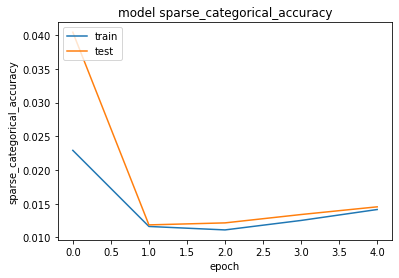

In [21]:
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

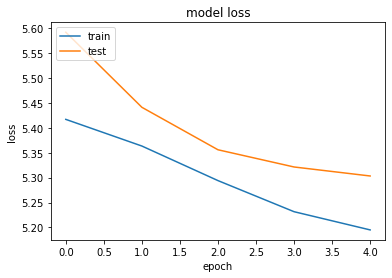

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("data/models/vf-imitation-model")

In [23]:
from pprint import pprint
import random
import numpy as np
import tensorflow as tf

from catanatron.game import Game
from catanatron.models.player import Player, RandomPlayer, Color
from catanatron.players.weighted_random import WeightedRandomPlayer
from catanatron_experimental.play import play_batch
from catanatron_gym.envs.catanatron_env import to_action_space, ACTION_SPACE_SIZE, from_action_space
from catanatron_gym.features import create_sample_vector, create_sample


class MyPlayer(Player):
    def decide(self, game, playable_actions):
        """Should return one of the playable_actions.

        Args:
            game (Game): complete game state. read-only.
            playable_actions (Iterable[Action]): options to choose from
        Return:
            action (Action): Chosen element of playable_actions
        """
        # ===== YOUR CODE HERE =====
        action_ints = [to_action_space(a) for a in playable_actions]
        mask = np.zeros(ACTION_SPACE_SIZE, dtype=np.float)
        mask[action_ints] = 1
        mask[mask == 0] = np.nan

        # Get action probabilities with neural network.
        vector = create_sample_vector(game, self.color)
        record = create_sample(game, self.color)
        keys = [name[2:] for name in INPUT_COLUMNS] # remove the F_ prefix
        vector = [record[x] for x in keys]
        X = [vector]
        result = model.call(tf.convert_to_tensor(X))

        # Multiply mask with output, and take max.
        clipped_probabilities = np.multiply(mask, result[0])
        clipped_probabilities[np.isnan(clipped_probabilities)] = -np.inf
        action_index = np.argmax(clipped_probabilities)
        action = from_action_space(action_index, playable_actions)
        
        # print(result)
        # print("Playing", action)
        
        return action
        # ===== END YOUR CODE =====

# Play a simple 4v4 game. Edit MyPlayer with your logic!
players = [
    MyPlayer(Color.RED),
    RandomPlayer(Color.WHITE),
]
wins, results_by_player, games = play_batch(5, players)

pprint(wins)
pprint(results_by_player)

# Results: [64, 32, 32] with LR 1e-4 made a bot that won 60% of games against Random. Had %60 categorical accuracy.

ImportError: cannot import name 'to_action_type_space' from 'catanatron_gym.envs.catanatron_env' (/home/bcollazo/BryanCode/catanatron/catanatron_gym/catanatron_gym/envs/catanatron_env.py)